In [1]:
import os
import yaml
import numpy as np
from math import sqrt,log10
import pylab as plt
from scipy.optimize import brentq, fmin
from scipy.interpolate import interp1d as interp
from scipy.interpolate import UnivariateSpline as spline
from sklearn.model_selection import LeaveOneOut
%matplotlib inline

In [16]:
J, L, a, b, c, r = np.load('results/MCtest.npy')

In [17]:
indLmin = np.where( L==min(L) )[0]
Lmin = L[indLmin][0]

In [18]:
cutL = L < int(Lmin)+50
for par in ['J', 'L', 'a', 'b', 'c', 'r']:
    exec( "{p} = {p}[cutL]".format(p=par) )

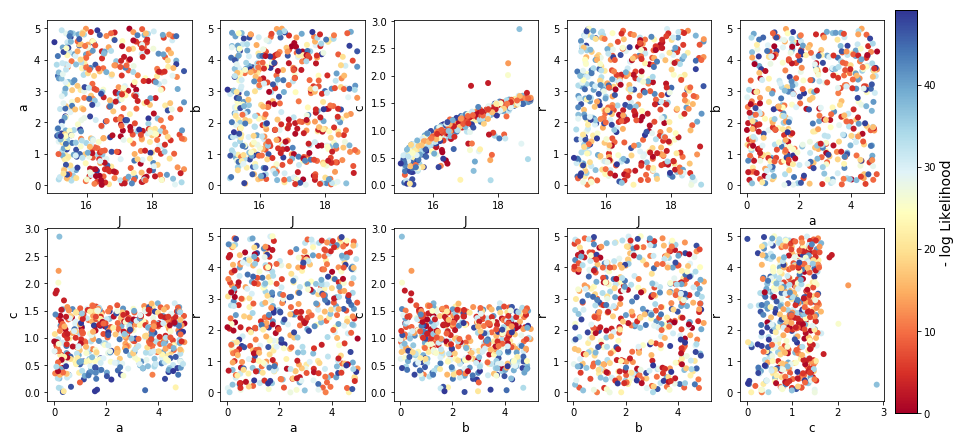

In [19]:
cm = plt.cm.get_cmap('RdYlBu')
pairs = [('J', 'a'), ('J', 'b'), ('J', 'c'), ('J', 'r'), ('a','b'), ('a','c'), ('a','r'), ('b','c'), ('b','r'), ('c','r')]
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15,7))
for dat, ax in zip(pairs, axes.flat):
    # The vmin and vmax arguments specify the color limits
    exec('xvalues = {}'.format(dat[0]) )
    exec('yvalues = {}'.format(dat[1]) )
    sc = ax.scatter( xvalues, yvalues, c=L-min(L), cmap=cm, lw=0 );
    ax.set_xlabel(dat[0], fontsize=12);
    ax.set_ylabel(dat[1], fontsize=12);
    cax = fig.add_axes([0.91, 0.1, 0.02, 0.8])
    cbar = fig.colorbar(sc, cax=cax);
    cbar.ax.set_ylabel('- log Likelihood', fontsize=14)
#plt.savefig('results/Like_Mc_scatterplots.png', dpi=300, format='png');

In [77]:
params = np.load('results/params_Mc_100p10000s.npy')
for i,p in enumerate(['J', 'L', 'a', 'b', 'c', 'r']):
    exec('{} = np.empty([0])'.format(p))
    exec('{p} = np.append({p}, [params[n][i] for n in range(len(params))])'.format(p=p))

In [78]:
LOOCV = LeaveOneOut()
smoothing = range(10,101)

In [79]:
RSS = []
for s in smoothing:
    score = []
    for train, test in LOOCV.split(J, L):
        spline_L = spline(J[train], L[train], s=s)
        score.append( (J[test] - spline_L(J[test]))**2 )
    RSS.append( sum(score) )

mins = np.where( RSS==min(RSS) )[0][0]

In [80]:
def rss(s, X, Y):
    score = 0
    for train, test in LOOCV.split(X, Y):
        spl = spline(X[train], Y[train], s=s)
        score += (X[test] - spl(X[test]))**2
    return score

In [81]:
res = fmin(rss, x0=70, args=(J,L))
res

Optimization terminated successfully.
         Current function value: 139221406.787729
         Iterations: 33
         Function evaluations: 69


array([ 75.29048491])

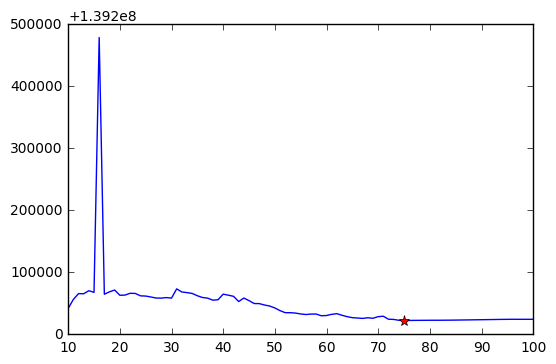

In [82]:
plt.plot(smoothing, RSS);
plt.plot(smoothing[mins], RSS[mins], 'r*', ms=8);

In [83]:
#s = smoothing[mins]
s = res
linear_L = interp(J, L)
spline_L = spline(J, L, s=s)

eval_Like_J = np.linspace(min(J), max(J), 1e3)
min_Like_J = spline_L(eval_Like_J).min()
Jmin = eval_Like_J[ np.where( spline_L(eval_Like_J) == min_Like_J )[0][0] ]
J_plt = np.linspace(min(J),max(J))

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:6: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


In [84]:
for par in ['a', 'b', 'c', 'r']:
    exec( 'pars = fmin(rss, x0=70, args=(J,{}))'.format(par))
    exec( 'spl_{par} = spline(J, {par}, s=pars)'.format(par=par))
    exec( 'J{0} = float(spl_{0}(Jmin))'.format(par) )

print 'r = %.2f, a = %.2f, b = %.2f, c = %.2f'%(Jr, Ja, Jb, Jc)

Optimization terminated successfully.
         Current function value: 24332.782089
         Iterations: 28
         Function evaluations: 57
Optimization terminated successfully.
         Current function value: 21183.465260
         Iterations: 20
         Function evaluations: 46
Optimization terminated successfully.
         Current function value: 25521.203850
         Iterations: 17
         Function evaluations: 50
Optimization terminated successfully.
         Current function value: 23714.747117
         Iterations: 27
         Function evaluations: 58
r = 3.34, a = 0.46, b = 3.82, c = 0.75


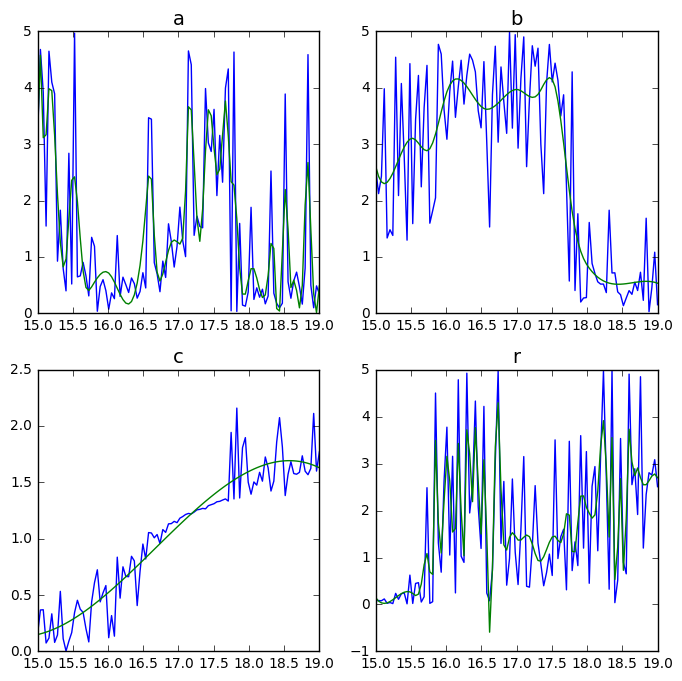

In [85]:
fig = plt.figure(figsize=(8,8))
for i,p in enumerate(['a', 'b', 'c', 'r']):
    ax = fig.add_subplot(2,2,i+1)
    ax.plot(J, eval( '{}'.format(p) ) );
    ax.plot(J, eval( 'spl_{}(J)'.format(p) ) );
    ax.set_title(p, fontsize=14);

In [86]:
for i,c in enumerate([0.5,2.0,4.5]):
    exec('J%ssL = %.2f'%(i+1, brentq(lambda j : spline_L(j)-spline_L(J).min()-c, min(J), Jmin) - Jmin))
    exec('J%ssR = %.2f'%(i+1, brentq(lambda j : spline_L(j)-spline_L(J).min()-c, Jmin, max(J)) - Jmin))

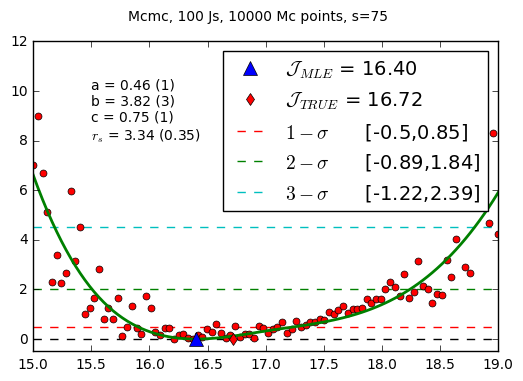

In [87]:
lin = linear_L(J)
spl = spline_L(J)
plt.plot(J, L-L.min(), 'ro', ms=5);
#plt.plot(J, lin-lin.min(), 'bo', ms=5);
plt.plot(J, spl-spl.min(), 'g', lw=2);

plt.hlines(0, min(J), max(J), linestyles='dashed')
plt.plot(Jmin, 0, 'b^', markersize=10, label=r'$\mathcal{J}_{MLE}$ = %.2f'%Jmin)
plt.plot(16.72, 0, 'rd', markersize=6, label=r'$\mathcal{J}_{TRUE}$ = 16.72')
for i,(c,h) in enumerate(zip(['r','g','c'],[0.5,2.0,4.5])):
    JL, JR = eval('J%ssL'%str(i+1)), eval('J%ssR'%str(i+1))
    plt.hlines(h, J_plt.min(), J_plt.max(), linestyles='dashed', colors=c,
              label=r'$%i-\sigma$'%(i+1)+'\t'+'[%2s,%2s]'%(str(JL),str(JR)))
plt.legend(numpoints=1,fontsize=14).get_frame().set_facecolor('w')
plt.text(15.5, 8,'a = %.2f (1)'%Ja +'\n'+
                 'b = %.2f (3)'%Jb +'\n'+
                 'c = %.2f (1)'%Jc +'\n'+
                 r'$r_s$ = %.2f (0.35)'%Jr)

plt.ylim(-0.5,12);
plt.suptitle("Mcmc, 100 Js, 10000 Mc points, s=%i"%s);
#plt.savefig('results/LikeJ_Mc10000_rabc_100p_CVs.png',format='png',dpi=300);

In [57]:
from scipy.stats import binned_statistic

Lmins = binned_statistic(J, L, statistic='min', bins=20)[0]

indxmins = np.where( [L==lm for lm in Lmins] )[1]

In [58]:
RSS = []
for s in smoothing:
    score = []
    for train, test in LOOCV.split(J[indxmins], L[indxmins]):
        spline_L = spline(J[train], L[train], s=s)
        score.append( (J[test] - spline_L(J[test]))**2 )
    RSS.append( sum(score) )

mins = np.where( RSS==min(RSS) )[0][0]

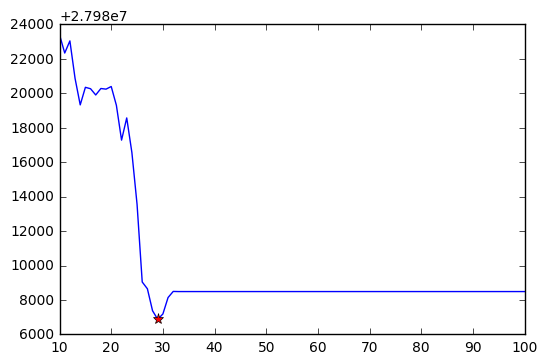

In [59]:
plt.plot(smoothing, RSS);
plt.plot(smoothing[mins], RSS[mins], 'r*', ms=8);

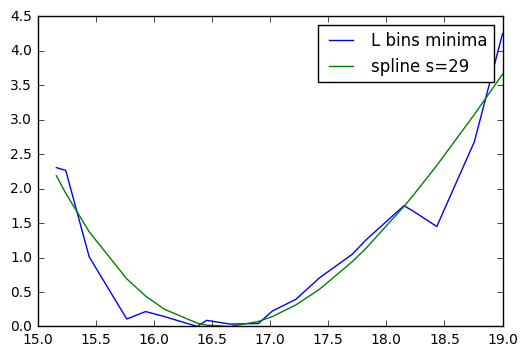

In [60]:
spline_mins = spline(J[indxmins], L[indxmins], s=smoothing[mins])
splminsL = spline_mins( J[indxmins] )
plt.plot(J[indxmins], L[indxmins]-min(L[indxmins]), label='L bins minima' );
plt.plot(J[indxmins], splminsL-min(splminsL), label='spline s=%g'%smoothing[mins] );
plt.legend();
#plt.savefig('results/envelope.png', dpi=300, format='png');

In [61]:
min_splnmins = spline_mins(eval_Like_J).min()
Jminspl = eval_Like_J[ np.where( spline_mins(eval_Like_J) == min_splnmins )[0][0] ]

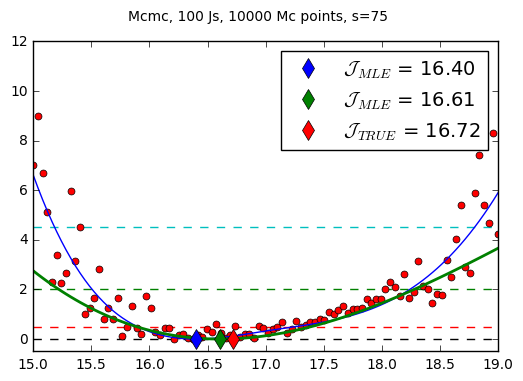

In [63]:
splmins = spline_mins(J)
plt.plot(J, L-L.min(), 'ro', ms=5);
#plt.plot(J, lin-min(lin), 'bo', ms=5);
plt.plot(J, spl-min(spl), 'b', lw=1);
plt.plot(J, splmins-min(splmins), 'g', lw=2);

plt.hlines(0, min(J), max(J), linestyles='dashed')
plt.plot(Jmin, 0, 'bd', markersize=10, label=r'$\mathcal{J}_{MLE}$ = %.2f'%Jmin)
plt.plot(Jminspl, 0, 'gd', markersize=10, label=r'$\mathcal{J}_{MLE}$ = %.2f'%Jminspl)
plt.plot(16.72, 0, 'rd', markersize=10, label=r'$\mathcal{J}_{TRUE}$ = 16.72')
for i,(c,h) in enumerate(zip(['r','g','c'],[0.5,2.0,4.5])):
    JL, JR = eval('J%ssL'%str(i+1)), eval('J%ssR'%str(i+1))
    plt.hlines(h, J_plt.min(), J_plt.max(), linestyles='dashed', colors=c,)
              #label=r'$%i-\sigma$'%(i+1)+'\t'+'[%2s,%2s]'%(str(JL),str(JR)))
plt.legend(numpoints=1,fontsize=14).get_frame().set_facecolor('w')
'''plt.text(15.5, 8,'a = %.2f (1)'%Ja +'\n'+
                 'b = %.2f (3)'%Jb +'\n'+
                 'c = %.2f (1)'%Jc +'\n'+
                 r'$r_s$ = %.2f (0.35)'%Jr)
'''
plt.ylim(-0.5,12);
plt.suptitle("Mcmc, 100 Js, 10000 Mc points, s=%i"%res);
#plt.savefig('results/LikeJ_Mc_envelope2.png',format='png',dpi=300);

In [30]:
Jminspl

16.493493493493492

In [98]:
LOOCV = LeaveOneOut()

In [99]:
def RSS(smoothing, X, Y):
    RSS = []
    for s in smoothing:
        score = []
        for train, test in LOOCV.split(X, Y):
            spline_L = spline(X[train], Y[train], s=s)
            score.append( (X[test] - spline_L(X[test]))**2 )
        RSS.append( sum(score) )
    return RSS

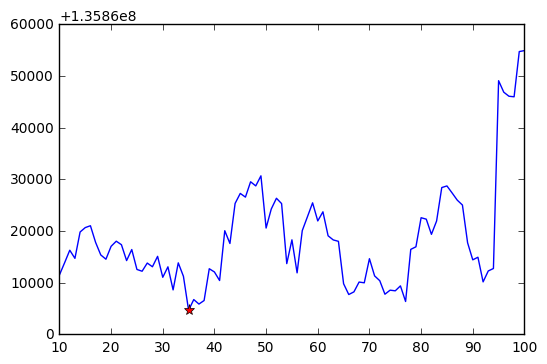

In [100]:
smoothing = range(10,101)
RSSL = RSS(smoothing, J, L)

mins = np.where( RSSL==min(RSSL) )[0][0]

plt.plot(smoothing, RSSL);
plt.plot(smoothing[mins], RSSL[mins], 'r*', ms=8);

In [101]:
S = smoothing[mins]
linear_L = interp(J, L)
spline_L = spline(J, L, s=S)

#eval_Like_J = np.linspace(min(J), max(J), 1e3)
#min_Like_J = min(spline_L(eval_Like_J))
#Jmin = eval_Like_J[ np.where( spline_L(eval_Like_J) == min_Like_J )[0][0] ]
J_plt = np.linspace(min(J), max(J))

In [102]:
Jmin = J[ np.where( spline_L(J)==min(spline_L(J)) ) ]

In [103]:
smoothing = range(10,101)
for par in ['a', 'b', 'c', 'r']:
    exec( 'RSSpar = RSS(smoothing, J, {})'.format(par) )
    minspar = np.where( RSSpar==min(RSSpar) )[0][0]
    exec( 'interp_{0} = spline(J, {0}, s=smoothing[minspar])'.format(par))
    exec( 'J{0} = float(interp_{0}(Jmin))'.format(par) )

print 'r = %.2f, a = %.2f, b = %.2f, c = %.2f'%(Jr, Ja, Jb, Jc)

r = 0.28, a = 1.11, b = 3.00, c = 0.98


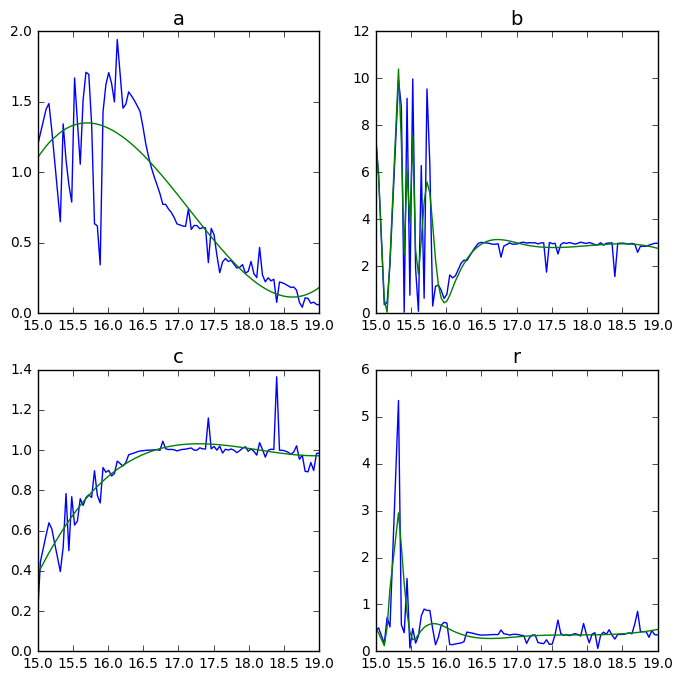

In [104]:
fig = plt.figure(figsize=(8,8))
for i,p in enumerate(['a', 'b', 'c', 'r']):
    ax = fig.add_subplot(2,2,i+1)
    ax.plot(J, eval( '{}'.format(p) ) );
    ax.plot(J, eval( 'interp_{}(J)'.format(p) ) );
    ax.set_title(p, fontsize=14);

In [105]:
for i,c in enumerate([0.5,2.0,4.5]):
    exec('J%ssL = %.2f'%(i+1, brentq(lambda j : spline_L(j)-spline_L(J).min()-c, J.min(), Jmin) - Jmin))
    exec('J%ssR = %.2f'%(i+1, brentq(lambda j : spline_L(j)-spline_L(J).min()-c, Jmin, J.max()) - Jmin))

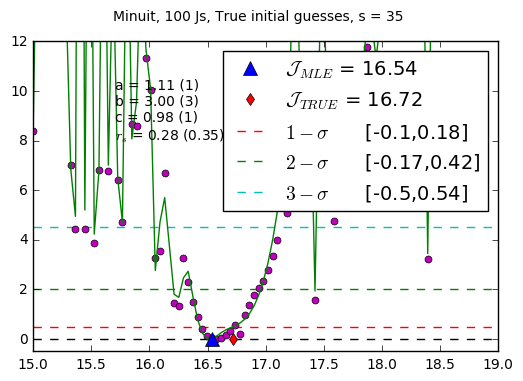

In [115]:
lin = linear_L(J)
spl = spline_L(J)
plt.plot(J, L-L.min(), 'mo', ms=5);
#plt.plot(J, lin-lin.min(), 'b');
plt.plot(J, spl-spl.min(), 'g');

plt.hlines(0, J.min(), J.max(), linestyles='dashed')
plt.plot(Jmin, 0, 'b^', markersize=10, label=r'$\mathcal{J}_{MLE}$ = %.2f'%Jmin)
plt.plot(16.72, 0, 'rd', markersize=6, label=r'$\mathcal{J}_{TRUE}$ = 16.72')
for i,(c,h) in enumerate(zip(['r','g','c'],[0.5,2.0,4.5])):
    JL, JR = eval('J%ssL'%str(i+1)), eval('J%ssR'%str(i+1))
    plt.hlines(h, J_plt.min(), J_plt.max(), linestyles='dashed', colors=c,
              label=r'$%i-\sigma$'%(i+1)+'\t'+'[%2s,%2s]'%(str(JL),str(JR)))
plt.legend(numpoints=1,fontsize=14).get_frame().set_facecolor('w')
plt.text(15.7, 8,'a = %.2f (1)'%Ja +'\n'+
                 'b = %.2f (3)'%Jb +'\n'+
                 'c = %.2f (1)'%Jc +'\n'+
                 r'$r_s$ = %.2f (0.35)'%Jr)

plt.ylim(-0.5,12);
plt.suptitle('Minuit, 100 Js, True initial guesses, s = %g'%S);
#plt.savefig('results/LikeJ_Min_rabc_100p_Tini_lin.png',format='png',dpi=300);

In [68]:
J, L, a, b, c, r = np.load('results/LikeJ1.npy')
linear_L = interp(J, L)

In [69]:
eval_Like_J = np.linspace(J.min(), J.max(), 100)
min_Like_J = linear_L(eval_Like_J).min()
Jmin = eval_Like_J[ np.where( linear_L(eval_Like_J) == min_Like_J )[0][0] ]

In [70]:
for par in ['a', 'b', 'c', 'r']:
    exec( 'spl_{par} = interp(J, {par})'.format(par=par))
    exec( 'J{0} = float(spl_{0}(Jmin))'.format(par) )

In [71]:
for i,c in enumerate([0.5,2.0,4.5]):
    exec('J%ssL = %.2f'%(i+1, brentq(lambda j : linear_L(j)-linear_L(J).min()-c, J.min(), Jmin) - Jmin))
    exec('J%ssR = %.2f'%(i+1, brentq(lambda j : linear_L(j)-linear_L(J).min()-c, Jmin, J.max()) - Jmin))

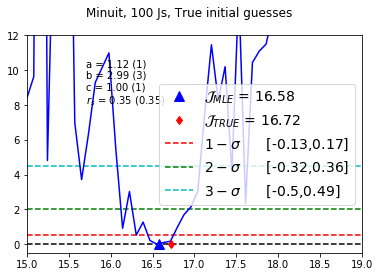

In [73]:
lin = linear_L(J)
plt.plot(J, lin-lin.min(), 'b');

plt.hlines(0, J.min(), J.max(), linestyles='dashed')
plt.plot(Jmin, 0, 'b^', markersize=10, label=r'$\mathcal{J}_{MLE}$ = %.2f'%Jmin)
plt.plot(16.72, 0, 'rd', markersize=6, label=r'$\mathcal{J}_{TRUE}$ = 16.72')
for i,(c,h) in enumerate(zip(['r','g','c'],[0.5,2.0,4.5])):
    JL, JR = eval('J%ssL'%str(i+1)), eval('J%ssR'%str(i+1))
    plt.hlines(h, J.min(), J.max(), linestyles='dashed', colors=c,
              label=r'$%i-\sigma$'%(i+1)+'\t'+'[%2s,%2s]'%(str(JL),str(JR)))
plt.legend(numpoints=1,fontsize=14).get_frame().set_facecolor('w')
plt.text(15.7, 8,'a = %.2f (1)'%Ja +'\n'+
                 'b = %.2f (3)'%Jb +'\n'+
                 'c = %.2f (1)'%Jc +'\n'+
                 r'$r_s$ = %.2f (0.35)'%Jr)

plt.ylim(-0.5,12);
plt.xlim(15, 19);
plt.suptitle('Minuit, 100 Js, True initial guesses');
#plt.savefig('results/LikeJ_Min_rabc_100p_Tini_lin.png',format='png',dpi=300);